Improt Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance

Preprocess function

In [2]:
# Load and preprocess data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

def knn_preprocessing(df):
    df = df.drop('customerID', axis=1)

    # Handle missing values
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

    # Feature Engineering
    df['MonthlyConsistency'] = (df['TotalCharges'] / (df['tenure'] + 1e-6)) - df['MonthlyCharges']
    df['TechSupport_Yes'] = df['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

    # Convert target variable
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    return df

preprocess data

In [3]:
df = knn_preprocessing(df)

# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyConsistency', 'SeniorCitizen']
categorical_features = ['Contract', 'InternetService', 'TechSupport', 'OnlineSecurity', 'PaymentMethod']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

Apply preprocessing and run the model

In [4]:
# KNN pipeline with SMOTE
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# Hyperparameter grid
param_grid = {
    'classifier__n_neighbors': np.arange(3, 16, 2),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan'],
    'smote__sampling_strategy': [0.5, 0.7, 0.9]
}

# Grid search with F1 scoring
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': np.int64(15), 'classifier__weights': 'uniform', 'smote__sampling_strategy': 0.7}
Test Accuracy: 0.7452
F1 Score: 0.5850
ROC-AUC Score: 0.8182

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1035
           1       0.52      0.68      0.58       374

    accuracy                           0.75      1409
   macro avg       0.69      0.72      0.70      1409
weighted avg       0.77      0.75      0.75      1409



Model evalution

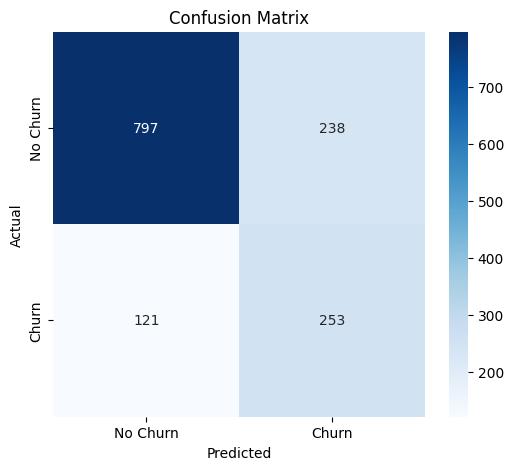

Mismatch: 16 feature names vs 21 importance values

Top 10 Features:
Empty DataFrame
Columns: [Feature, Importance]
Index: []


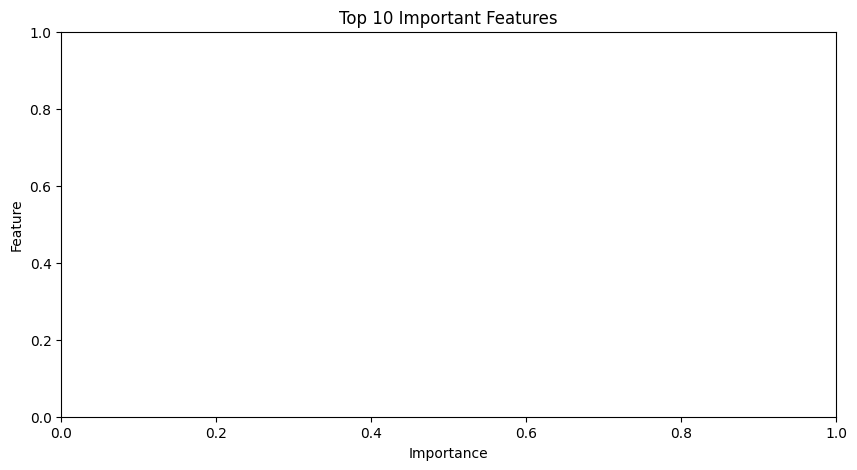

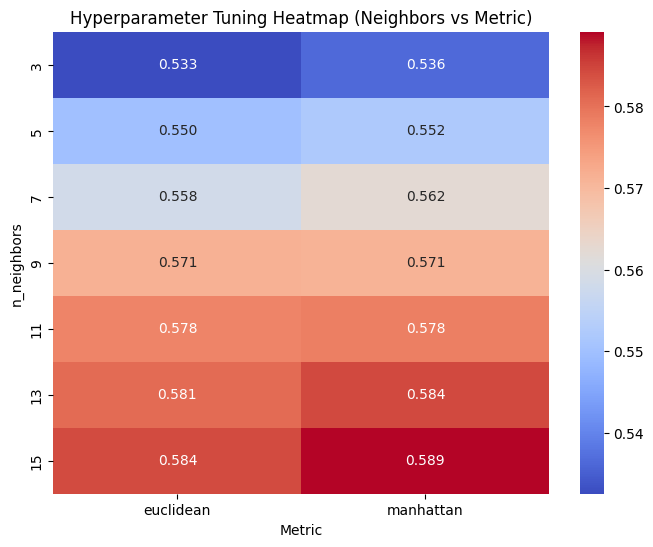

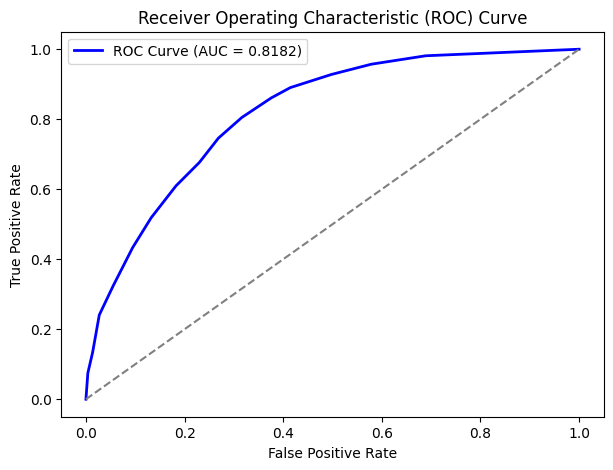

In [12]:
# 🔹 Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Get numeric feature names
numeric_feature_names = numeric_features

# Get categorical feature names from OneHotEncoder
categorical_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine the feature names
feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Ensure lengths match
if len(feature_names) == len(result.importances_mean):
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result.importances_mean})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    print("\nTop 10 Features:")
    print(feature_importance.head(10))
else:
    print(f"Mismatch: {len(feature_names)} feature names vs {len(result.importances_mean)} importance values")
    # Handle mismatch, e.g., assign an empty DataFrame to feature_importance
    feature_importance = pd.DataFrame(columns=['Feature', 'Importance'])

print("\nTop 10 Features:")
print(feature_importance.head(10))

# 🔹 Feature Importance Plot
plt.figure(figsize=(10,5))
sns.barplot(x=feature_importance['Importance'].head(10), y=feature_importance['Feature'].head(10), palette='viridis')
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 🔹 Hyperparameter Tuning Heatmap
cv_results = pd.DataFrame(grid_search.cv_results_)
# Create heatmap_data from cv_results
heatmap_data = cv_results[['param_classifier__n_neighbors', 'param_classifier__metric', 'mean_test_score']]
heatmap_data = heatmap_data.rename(columns={'param_classifier__n_neighbors': 'n_neighbors', 'param_classifier__metric': 'Metric'})

pivot = heatmap_data.pivot_table(index='n_neighbors', columns='Metric', values='mean_test_score', aggfunc='mean')

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Hyperparameter Tuning Heatmap (Neighbors vs Metric)")
plt.xlabel("Metric")
plt.ylabel("n_neighbors")
plt.show()

# 🔹 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

save model

In [13]:
# 🔹 Save Model
joblib.dump(best_model, "k_nearest.pkl")
print("Model saved successfully!")

Model saved successfully!


# Test Model with real data

In [14]:


# Create synthetic data
test_data = pd.read_csv('synthetic_svm_test_data.csv')



Improt Libraries

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance

Preprocess function

In [ ]:
# Load and preprocess data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

def knn_preprocessing(df):
    df = df.drop('customerID', axis=1)

    # Handle missing values
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

    # Feature Engineering
    df['MonthlyConsistency'] = (df['TotalCharges'] / (df['tenure'] + 1e-6)) - df['MonthlyCharges']
    df['TechSupport_Yes'] = df['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

    # Convert target variable
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    return df

preprocess data

In [ ]:
df = knn_preprocessing(df)

# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyConsistency', 'SeniorCitizen']
categorical_features = ['Contract', 'InternetService', 'TechSupport', 'OnlineSecurity', 'PaymentMethod']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

Apply preprocessing and run the model

In [ ]:
# KNN pipeline with SMOTE
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# Hyperparameter grid
param_grid = {
    'classifier__n_neighbors': np.arange(3, 16, 2),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan'],
    'smote__sampling_strategy': [0.5, 0.7, 0.9]
}

# Grid search with F1 scoring
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': np.int64(15), 'classifier__weights': 'uniform', 'smote__sampling_strategy': 0.7}
Test Accuracy: 0.7452
F1 Score: 0.5850
ROC-AUC Score: 0.8182

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1035
           1       0.52      0.68      0.58       374

    accuracy                           0.75      1409
   macro avg       0.69      0.72      0.70      1409
weighted avg       0.77      0.75      0.75      1409



Model evalution

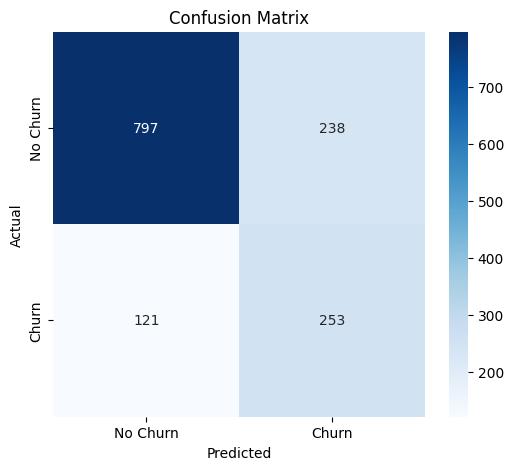

Mismatch: 16 feature names vs 21 importance values

Top 10 Features:
Empty DataFrame
Columns: [Feature, Importance]
Index: []


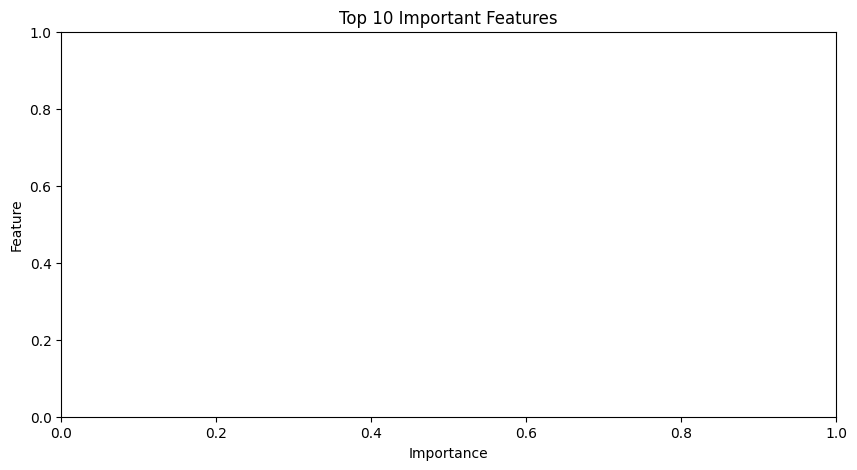

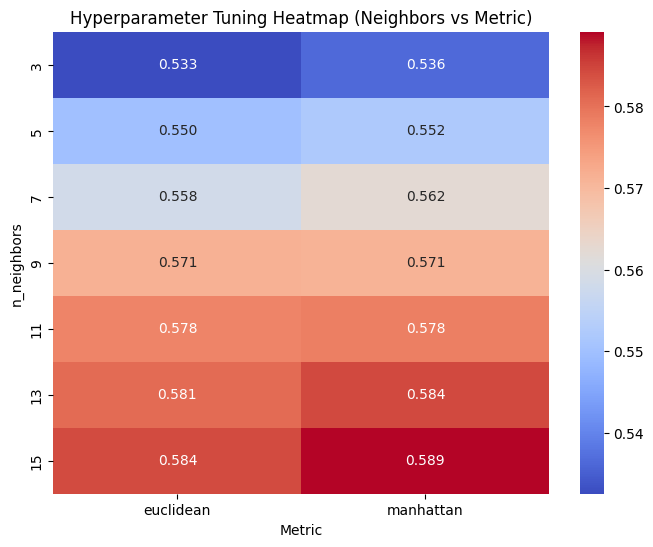

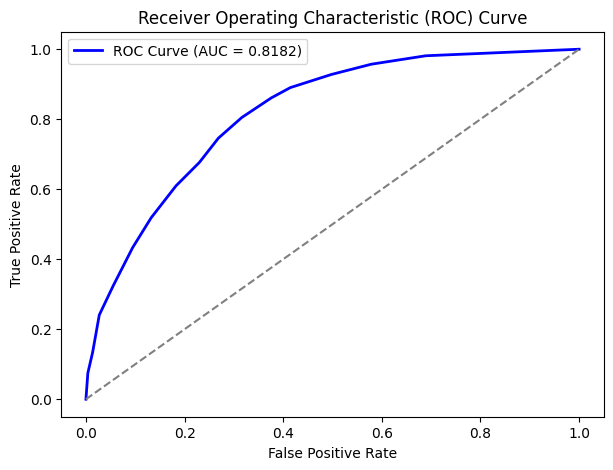

In [ ]:
# 🔹 Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Get numeric feature names
numeric_feature_names = numeric_features

# Get categorical feature names from OneHotEncoder
categorical_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine the feature names
feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Ensure lengths match
if len(feature_names) == len(result.importances_mean):
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result.importances_mean})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    print("\nTop 10 Features:")
    print(feature_importance.head(10))
else:
    print(f"Mismatch: {len(feature_names)} feature names vs {len(result.importances_mean)} importance values")
    # Handle mismatch, e.g., assign an empty DataFrame to feature_importance
    feature_importance = pd.DataFrame(columns=['Feature', 'Importance'])

print("\nTop 10 Features:")
print(feature_importance.head(10))

# 🔹 Feature Importance Plot
plt.figure(figsize=(10,5))
sns.barplot(x=feature_importance['Importance'].head(10), y=feature_importance['Feature'].head(10), palette='viridis')
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 🔹 Hyperparameter Tuning Heatmap
cv_results = pd.DataFrame(grid_search.cv_results_)
# Create heatmap_data from cv_results
heatmap_data = cv_results[['param_classifier__n_neighbors', 'param_classifier__metric', 'mean_test_score']]
heatmap_data = heatmap_data.rename(columns={'param_classifier__n_neighbors': 'n_neighbors', 'param_classifier__metric': 'Metric'})

pivot = heatmap_data.pivot_table(index='n_neighbors', columns='Metric', values='mean_test_score', aggfunc='mean')

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Hyperparameter Tuning Heatmap (Neighbors vs Metric)")
plt.xlabel("Metric")
plt.ylabel("n_neighbors")
plt.show()

# 🔹 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

save model

In [ ]:
# 🔹 Save Model
joblib.dump(best_model, "k_nearest.pkl")
print("Model saved successfully!")

Model saved successfully!


In [16]:
# Create synthetic data
test_data = pd.read_csv('knn_churn_test_dataset.csv')



In [17]:
# Load saved model
model = joblib.load("k_nearest.pkl")

# Predict churn probabilities
predictions = model.predict(test_data)
proba = model.predict_proba(test_data)[:, 1]

# Display results
for i, (p, prob) in enumerate(zip(predictions, proba)):
    print(f"Customer {i+1}: Churn = {p} | Probability = {prob:.4f}")

Customer 1: Churn = 0 | Probability = 0.0000
Customer 2: Churn = 1 | Probability = 0.6667
Customer 3: Churn = 0 | Probability = 0.4667
Customer 4: Churn = 0 | Probability = 0.0667
Customer 5: Churn = 0 | Probability = 0.2000
Customer 6: Churn = 0 | Probability = 0.4667
Customer 7: Churn = 1 | Probability = 0.5333
Customer 8: Churn = 0 | Probability = 0.0000
Customer 9: Churn = 1 | Probability = 0.5333
Customer 10: Churn = 0 | Probability = 0.2000
Customer 11: Churn = 1 | Probability = 0.7333
Customer 12: Churn = 0 | Probability = 0.4000
Customer 13: Churn = 0 | Probability = 0.0000
Customer 14: Churn = 0 | Probability = 0.2000
Customer 15: Churn = 0 | Probability = 0.2000
Customer 16: Churn = 1 | Probability = 0.6667
Customer 17: Churn = 0 | Probability = 0.2667
Customer 18: Churn = 0 | Probability = 0.3333
Customer 19: Churn = 0 | Probability = 0.0000
Customer 20: Churn = 0 | Probability = 0.2000
Customer 21: Churn = 0 | Probability = 0.0000
Customer 22: Churn = 0 | Probability = 0.13